# Logistic regression using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, model_selection as ms

%matplotlib inline

* [Original publication](http://dx.doi.org/10.1371/journal.pone.0137524)
* [Dataset](http://dx.doi.org/10.5061/dryad.8jq92)

In [2]:
GLIOMA_URL = 'http://datadryad.org/bitstream/handle/10255/dryad.88928/An%20eighteen%20serum%20cytokine%20signature%20for%20discriminating%20glioma%20from%20normal%20healthy%20individuals%20raw%20data.xlsx?sequence=1'

In [3]:
glioma = pd.read_excel(GLIOMA_URL)

Transpose DataFrame so that measurements are in columns.

In [4]:
glioma = glioma.transpose()

Set first row as column names, then drop it.

In [5]:
glioma.columns = glioma.iloc[0]
glioma.columns.name = ''
glioma = glioma.reindex(glioma.index.drop('sample'))

Extract cytokine measurements.

In [6]:
X = glioma.iloc[:,1:].apply(pd.to_numeric, axis=1)

Apply logarithmic transformation to each measurement.

In [7]:
X = X.apply(np.log, axis=1)

Dichotomise outcome: GBM versus rest.

* DA = Diffuse Astrocytoma (grade II)
* AA = Anaplastic Astrocytoma (grade III)
* GBM = Glioblastoma Multiforme (grade IV)

In [8]:
y = glioma.Type == 'GBM'

## Logistic regression

Fit the model.

**Note**: by default, `scikit-learn` uses $L_{2}$ regularisation with parameter `C` (default = 1). This cannot be disabled, but we can set `C` so big that it has little effect.

In [9]:
model1 = lm.LogisticRegression(C=1e50)
model1.fit(X, y)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Print regression coefficients.

In [10]:
model1.intercept_

array([ 2.59983768])

In [11]:
model1.coef_

array([[  0.3685038 ,  -6.68987779,  20.26060715,  -4.84749947,
         -5.03132802,  -4.53010318,   5.77783412,  -1.20414406,
          1.97712875,  -0.36768865,  19.83115924, -11.3313795 ,
         -9.22368975,   3.36535531,  -5.10200119,  -0.06020032,
          2.49228036,  -8.86554212,   0.4424792 , -15.77054193,
         -9.15381798,   6.78637093,   9.18630776, -27.69152389,
         20.07872275,   0.71891037,  -7.08665041,   9.71225346,
         -0.43090571,  -2.13936243,   0.11798241,  -3.30839892,
         -0.1458376 , -10.37538164,   5.11989368,   6.37386555,
         -0.61567845,   3.52701839,  -5.46040197,   9.92533607,
         -0.72621998,  13.33588691,  -9.57479981,  -5.92775118,
          2.0528968 ,  -2.37407981,   3.74062175,  -3.21212373]])

Print odds ratios.

In [12]:
np.exp(model1.intercept_)

array([ 13.46155272])

In [13]:
np.exp(model1.coef_)

array([[  1.44557013e+00,   1.24343472e-03,   6.29607492e+08,
          7.84797711e-03,   6.53013268e-03,   1.07795638e-02,
          3.23058726e+02,   2.99948626e-01,   7.22197709e+00,
          6.92332709e-01,   4.09791576e+08,   1.19906965e-05,
          9.86739329e-05,   2.89437795e+01,   6.08455799e-03,
          9.41575901e-01,   1.20888115e+01,   1.41170508e-04,
          1.55656146e+00,   1.41560035e-07,   1.05815031e-04,
          8.85693474e+02,   9.76253868e+03,   9.41291161e-13,
          5.24902323e+08,   2.05219585e+00,   8.36193589e-04,
          1.65187843e+04,   6.49920189e-01,   1.17729880e-01,
          1.12522432e+00,   3.65746860e-02,   8.64298056e-01,
          3.11909790e-05,   1.67317579e+02,   5.86319904e+02,
          5.40274222e-01,   3.40223747e+01,   4.25184628e-03,
          2.04417789e+04,   4.83734062e-01,   6.19016313e+05,
          6.94572006e-05,   2.66446718e-03,   7.79043575e+00,
          9.31001193e-02,   4.21241728e+01,   4.02709978e-02]])

Compute classification accuracy.

In [14]:
metrics.accuracy_score(y, model1.predict(X))

1.0

Compute confusion matrix.

In [15]:
metrics.confusion_matrix(y, model1.predict(X))

array([[ 72,   0],
       [  0, 148]])

## ROC analysis

Compute predicted probabilities for GBM (`y` = 1).

In [16]:
pred_probs = model1.predict_proba(X)[:,1]

Visualise distribution.

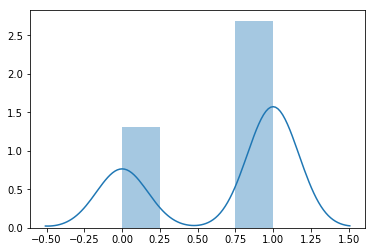

In [17]:
sns.distplot(pred_probs)

Define a set of cut-off values where sensitivity and specificity will be computed.

In [18]:
cutoffs = np.linspace(0, 1, 1001)

Define a function to compute specificity.

In [19]:
def specificity_score(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

Compute sensitivity and specificity at the cut-off values defined above.

In [20]:
sensitivities = np.zeros(cutoffs.size)
specificities = np.zeros(cutoffs.size)
for i, cutoff in enumerate(cutoffs):
    sensitivities[i] = metrics.recall_score(y, pred_probs >= cutoff)
    specificities[i] = specificity_score(y, pred_probs >= cutoff)

Plot the ROC curve, i.e. sensitivity versus (1 - specificity).

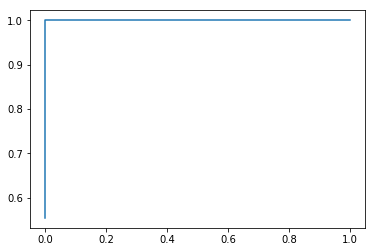

In [21]:
plt.plot(1 - specificities, sensitivities)

Alternatively…

(FPR = 1 - specificity; TPR = sensitivity)

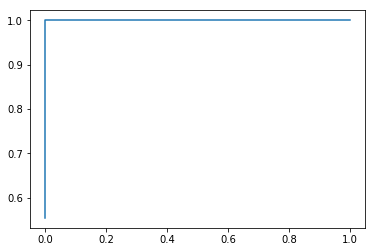

In [22]:
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)
plt.plot(fpr, tpr)

Compute area under the ROC curve (AUC).

In [23]:
metrics.roc_auc_score(y, pred_probs)

1.0

## Cross-validation

Define stratified folds.

In [24]:
five_fold_cv = ms.StratifiedKFold(n_splits=5, shuffle=True)

Compute average classification accuracy across folds.

In [25]:
accuracies = ms.cross_val_score(lm.LogisticRegression(C=1e50), X, y, scoring='accuracy', cv=five_fold_cv)
np.mean(accuracies)

0.84094902513507164

Compute average AUC across folds.

In [26]:
aucs = ms.cross_val_score(lm.LogisticRegression(C=1e50), X, y, scoring='roc_auc', cv=five_fold_cv)
np.mean(aucs)

0.91375478927203058

## Regularisation

### $L_{2}$ regularisation

Determine 'optimal' value of `C` by cross-validation using AUC scoring
(`scikit-learn` uses $L_{2}$ regularisation by default).

In [27]:
Cs = np.logspace(-4, 4, 10)
gs = ms.GridSearchCV(
    estimator=lm.LogisticRegression(),
    param_grid={'C': Cs},
    scoring='roc_auc',
    cv=five_fold_cv
)
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [28]:
gs.best_score_

0.94419017763845337

In [29]:
gs.best_estimator_

LogisticRegression(C=0.35938136638046259, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Plot `C`s against AUC scores.

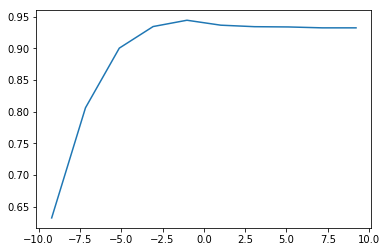

In [30]:
plt.plot(np.log(Cs), gs.cv_results_['mean_test_score'])

Alternatively…

In [31]:
model2 = lm.LogisticRegressionCV(Cs=10, cv=five_fold_cv, scoring='roc_auc')
model2.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

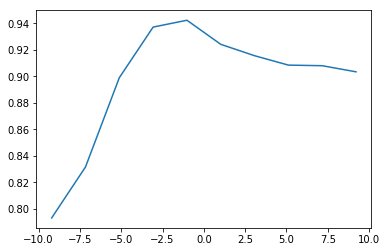

In [32]:
plt.plot(np.log(model2.Cs_), model2.scores_[1].mean(axis=0))

In [33]:
np.exp(model2.intercept_)

array([ 3.97606171])

In [34]:
np.exp(model2.coef_)

array([[ 0.61451575,  0.66372079,  1.68046274,  0.74739021,  0.66616013,
         0.59120609,  1.80806724,  1.03486911,  0.91946612,  0.87505033,
         2.47611279,  0.54677722,  0.60311357,  1.09374536,  1.15308573,
         1.1213609 ,  1.25625235,  0.6580992 ,  1.08351031,  0.54618329,
         0.52312209,  1.00410791,  1.2629019 ,  0.45159828,  3.59119279,
         1.30029569,  0.71753024,  0.79508586,  1.47449639,  0.74966155,
         0.75519658,  0.80450449,  0.97561191,  1.06281664,  1.12628916,
         1.84856964,  0.99733654,  1.18527773,  0.75585894,  1.9229324 ,
         0.77163236,  1.4383677 ,  0.65151466,  0.74248048,  1.16304132,
         0.99232474,  1.59539266,  0.85768281]])

### $L_{1}$ regularisation

In [35]:
model3 = lm.LogisticRegressionCV(Cs=10, cv=five_fold_cv, penalty='l1', scoring='roc_auc', solver='liblinear')
model3.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

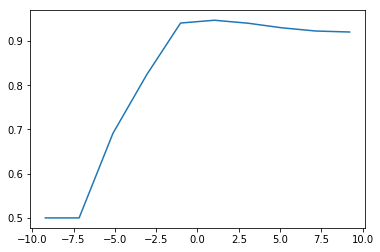

In [36]:
plt.plot(np.log(model3.Cs_), model3.scores_[1].mean(axis=0))

In [37]:
np.exp(model3.intercept_)

array([ 1.])

In [38]:
np.exp(model3.coef_)

array([[  0.55229201,   0.86415719,  16.56387503,   0.53707225,
          0.34338041,   0.71915309,   2.63262942,   1.        ,
          1.        ,   0.82349175,  14.97791187,   0.16477727,
          0.27148211,   1.32721012,   1.        ,   1.00428355,
          1.66315663,   0.39575767,   1.0361976 ,   0.04796344,
          0.31170385,   1.11655116,   2.93675778,   0.02444265,
         22.47373049,   1.        ,   0.47438675,   1.094046  ,
          1.04448257,   0.56435885,   1.        ,   0.66925089,
          0.88347814,   0.51464555,   1.        ,   3.04351585,
          1.        ,   1.35297482,   0.48666787,   4.88555543,
          0.63197602,   9.65888737,   0.47860176,   0.55899083,
          1.40065705,   1.        ,   2.53503585,   0.51005313]])

## Multiple classes

Check the argument `multi_class`:
* 'ovr' means that binary models are estimated for each class
* 'multinomial' means that a single multinomial model is estimated

In [39]:
model4 = lm.LogisticRegression(C=1e50, solver='lbfgs', multi_class='multinomial')
model4.fit(X, glioma.Type)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
model4.classes_

array(['AA', 'DA', 'GBM', 'Normal'], dtype=object)

In [41]:
np.exp(model4.intercept_)

array([ 0.36523499,  1.4125601 ,  1.78196863,  1.08772883])

In [42]:
np.exp(model4.coef_)

array([[  1.66383644e+02,   1.18553845e+15,   6.73133352e-10,
          5.17208070e+23,   4.40882120e+35,   1.36581846e+33,
          1.49331608e-07,   6.84356575e-01,   5.39711285e+07,
          3.36597764e+10,   1.60333378e+00,   2.86020587e+04,
          2.14505224e+07,   9.61411215e+23,   8.01140373e+42,
          6.56783659e-25,   4.90652389e-01,   3.16035396e+44,
          7.40903451e+00,   1.99437316e+25,   2.32833083e+28,
          3.20462741e-06,   1.54099631e+10,   4.59769449e-10,
          3.50371144e-51,   5.53995133e-15,   1.61047103e+18,
          4.01319920e+06,   2.33985835e-05,   3.17216239e-12,
          1.95600331e+08,   2.67862250e-04,   1.13174881e-16,
          4.25859310e-09,   1.57911861e+02,   1.50712087e+00,
          2.67513712e-14,   1.27131399e-06,   5.66780644e+00,
          4.05108882e-17,   1.51499906e-06,   8.53886111e-02,
          1.13122601e+04,   1.44768224e+00,   1.64102724e+01,
          3.93424406e-10,   1.48878208e-09,   7.35387585e-11],
       